In [1]:
%env XLA_PYTHON_CLIENT_PREALLOCATE=false
%config InlineBackend.figure_format='png'
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc, font_manager, ticker, patches, legend_handler, \
    gridspec
import seaborn as sns
import pandas as pd
import metrics
import wandb
import copy
import pathlib
import json
import yaml
import pprint

sns.set_theme()

env: XLA_PYTHON_CLIENT_PREALLOCATE=false


In [50]:
runs_path = pathlib.Path('/iris/u/kylehsu/runs/modular/2024-09-25/09-52-35')
rows = []
for run in range(130):
    summary = json.load(
        open(
            runs_path / f'{run}' / 'wandb' / 'latest-run' / 'files' / 'wandb-summary.json', 'r'
            )
        )
    config = yaml.safe_load(
        open(
            runs_path / f'{run}' / 'wandb' / 'latest-run' / 'files' / 'config.yaml', 'r'
            )
        )
    name = config['data']['value']['name']
    row = {
        'name':               name,
        'group':              name[:name.find(':') if ':' in name else None],
        'source_nmi':         np.round(summary['source_normalized_multiinformation'], 3),
        'infom/iid':          summary['metrics/infom/iid'],
        'infom/independent':  summary['metrics/infom/independent'],
        'cinfom/iid':         summary['metrics/cinfom/iid'],
        'cinfom/independent': summary['metrics/cinfom/independent'],
        'seed':               config['experiment']['value']['seed']
    }
    
    if row['group'] == 'independent':
        for group in ['diagonal_strengthen', 'diagonal_remove', 'corner']:
            duplicate_row = copy.deepcopy(row)
            duplicate_row['group'] = group
            rows.append(duplicate_row)
    else:
        rows.append(row)
    
df = pd.DataFrame(rows)
df.to_csv('results_isaac3d.csv')

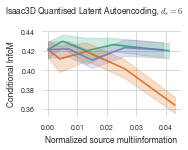

In [8]:
df = pd.read_csv('results_isaac3d.csv')
sns.set_theme(
    context='paper',
    style='whitegrid',
    font='Helvetica Neue',
    rc={
        'figure.constrained_layout.use':   True,
        # 'text.usetex':                      True,
        # 'font.family':                      'Helvetica',
        # 'text.latex.preamble':              r'\usepackage{bm}',
        'legend.framealpha':               1.0,
        'savefig.dpi':                     600,
        'savefig.pad_inches':              0.05,
        'savefig.transparent':             True,
        'mathtext.fontset':                'cm',
        'axes.formatter.use_mathtext':     True,
        'axes.labelsize':                  6,
        'axes.titlesize':                  6,
        'figure.titlesize':                6,
        'axes.labelpad':                   3,
        'xtick.labelsize':                 5,
        'xtick.major.pad':                 -0.5,
        'ytick.labelsize':                 5,
        'ytick.major.pad':                 -0.5,
        'grid.linewidth':                  0.5,
        'legend.fontsize':                 5,
        'hatch.linewidth':                 0.3,
        'lines.linewidth':                 1.2,
        'lines.markersize':                10,
        'figure.constrained_layout.w_pad': 0.03,
        'figure.constrained_layout.h_pad': 0.05
    }
)
fig, ax = plt.subplots(figsize=(1.8, 1.5))
sns.set_palette('Dark2')
sns.lineplot(
    data=df,
    x='source_nmi',
    y='cinfom/iid',
    hue='group',
    hue_order=['diagonal_strengthen', 'corner', 'diagonal_remove'],
    markers=True,
    errorbar=('se', 0.75),
    ax=ax,
    alpha=0.8
)
ax.legend().set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_xlabel('Normalized source multiinformation')
ax.set_ylabel('Conditional InfoM')
fig.suptitle(r'Isaac3D Quantised Latent Autoencoding, $d_s=6$')
plt.savefig('autoencoder_isaac3d.pdf')

In [6]:
datasets = np.load('low_d_sources.npz')
name_to_source_nmi = {}
for k, v in datasets.items():
    name_to_source_nmi[k] = metrics.multiinformation(v)['normalized_mi']

# update from wandb api to processing local: /iris/u/kylehsu/runs/modular_backup/2024-09-19/17-17-38

api = wandb.Api()
runs = list(
    api.runs(
        'iris_viscam/modular',
        {
            '$or': [{'config.wandb.group': 'arxiv_low_d'}],
        }
    )
)

rows = []
for run in runs:
    if run.state != 'finished':
        continue
    if run.summary['loss/reconstruction/iid'] > 0.00015:
        continue
    config = run.config
    name = config['data']['name']
    row = {
        'name':               name,
        'infom/iid':          run.summary['metrics/infom/iid'],
        'infom/independent':  run.summary['metrics/infom/independent'],
        'cinfom/iid':         run.summary['metrics/cinfom/iid'],
        'cinfom/independent': run.summary['metrics/cinfom/independent'],
        'source_nmi':         name_to_source_nmi[
                                  name] if 'strengthen' not in name else
                              name_to_source_nmi[name] * 1.2,
        'group':              name[:name.find(':') if ':' in name else None],
        'seed':               config['experiment']['seed']
    }
    if row['group'] == 'independent':
        for group in ['diagonal_strengthen', 'diagonal_remove', 'corner']:
            duplicate_row = copy.deepcopy(row)
            duplicate_row['group'] = group
            rows.append(duplicate_row)
    else:
        rows.append(row)
df = pd.DataFrame(rows)
print(len(df))

0


In [104]:
name_to_source_nmi


{'independent': 0.0,
 'corner:0.3': 0.000955267372164789,
 'corner:0.4': 0.0020035117766182197,
 'corner:0.5': 0.003585379486260969,
 'corner:0.6': 0.005779109562312258,
 'corner:0.7': 0.008649261373352084,
 'corner:0.8': 0.012247065858933346,
 'corner:0.9': 0.016606835529491114,
 'corner:1.0': 0.021731746103632592,
 'diagonal_strengthen:10': 0.0011265954379853092,
 'diagonal_strengthen:20': 0.0015987361723001057,
 'diagonal_strengthen:30': 0.0030930405786230622,
 'diagonal_strengthen:50': 0.005364873252162858,
 'diagonal_strengthen:100': 0.007599935393483247,
 'diagonal_strengthen:150': 0.011278676080111447,
 'diagonal_strengthen:200': 0.014118843506278698,
 'diagonal_strengthen:300': 0.017908813624236304,
 'diagonal_remove:0.1': 0.0016242515737922697,
 'diagonal_remove:0.2': 0.00391426577127438,
 'diagonal_remove:0.3': 0.005191807619402024,
 'diagonal_remove:0.4': 0.008643758713403627,
 'diagonal_remove:0.5': 0.011188203929258456,
 'diagonal_remove:0.6': 0.012683470606164997,
 'diago

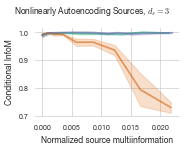

In [105]:
sns.set_theme(
    context='paper',
    style='whitegrid',
    font='Helvetica Neue',
    rc={
        'figure.constrained_layout.use':   True,
        # 'text.usetex':                      True,
        # 'font.family':                      'Helvetica',
        # 'text.latex.preamble':              r'\usepackage{bm}',
        'legend.framealpha':               1.0,
        'savefig.dpi':                     600,
        'savefig.pad_inches':              0.05,
        'savefig.transparent':             True,
        'mathtext.fontset':                'cm',
        'axes.formatter.use_mathtext':     True,
        'axes.labelsize':                  6,
        'axes.titlesize':                  6,
        'figure.titlesize':                6,
        'axes.labelpad':                   3,
        'xtick.labelsize':                 5,
        'xtick.major.pad':                 -0.5,
        'ytick.labelsize':                 5,
        'ytick.major.pad':                 -0.5,
        'grid.linewidth':                  0.5,
        'legend.fontsize':                 5,
        'hatch.linewidth':                 0.3,
        'lines.linewidth':                 1.2,
        'lines.markersize':                10,
        'figure.constrained_layout.w_pad': 0.03,
        'figure.constrained_layout.h_pad': 0.05
    }
)
fig, ax = plt.subplots(figsize=(1.8, 1.5))
sns.set_palette('Dark2')
sns.lineplot(
    data=df,
    x='source_nmi',
    y='cinfom/iid',
    hue='group',
    hue_order=['diagonal_strengthen', 'corner', 'diagonal_remove'],
    markers=True,
    errorbar=('se', 1),
    ax=ax,
    alpha=0.6
)
ax.legend().set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_xlabel('Normalized source multiinformation')
ax.set_ylabel('Conditional InfoM')
fig.suptitle(r'Nonlinearly Autoencoding Sources, $d_s=3$')
plt.savefig('autoencoder_low_d.pdf')


Text(0.5, 0.98, 'Nonlinearly Autoencoding Sources, $d_s=3$')

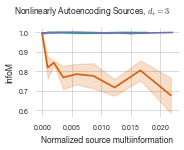

In [81]:
sns.set_theme(
    context='paper',
    style='whitegrid',
    font='Helvetica Neue',
    rc={
        'figure.constrained_layout.use':   True,
        # 'text.usetex':                      True,
        # 'font.family':                      'Helvetica',
        # 'text.latex.preamble':              r'\usepackage{bm}',
        'legend.framealpha':               1.0,
        'savefig.dpi':                     600,
        'savefig.pad_inches':              0.05,
        'savefig.transparent':             True,
        'mathtext.fontset':                'cm',
        'axes.formatter.use_mathtext':     True,
        'axes.labelsize':                  6,
        'axes.titlesize':                  6,
        'figure.titlesize':                6,
        'axes.labelpad':                   3,
        'xtick.labelsize':                 5,
        'xtick.major.pad':                 -0.5,
        'ytick.labelsize':                 5,
        'ytick.major.pad':                 -0.5,
        'grid.linewidth':                  0.5,
        'legend.fontsize':                 5,
        'hatch.linewidth':                 0.3,
        'lines.linewidth':                 1.2,
        'lines.markersize':                10,
        'figure.constrained_layout.w_pad': 0.03,
        'figure.constrained_layout.h_pad': 0.05
    }
)
fig, ax = plt.subplots(figsize=(1.8, 1.5))
sns.set_palette('Dark2')
sns.lineplot(
    data=df,
    x='source_nmi',
    y='infom/independent',
    hue='group',
    hue_order=['diagonal_strengthen', 'corner', 'diagonal_remove'],
    markers=True,
    errorbar=('se', 1),
    ax=ax,
)
ax.legend().set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_xlabel('Normalized source multiinformation')
ax.set_ylabel('InfoM')
fig.suptitle(r'Nonlinearly Autoencoding Sources, $d_s=3$')
# plt.savefig('autoencoder_low_d_infom_independent.pdf')

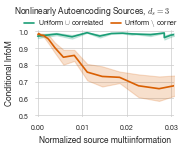

In [47]:
sns.set_theme(
    context='paper',
    style='whitegrid',
    font='Helvetica Neue',
    rc={
        'figure.constrained_layout.use':   True,
        # 'text.usetex':                      True,
        # 'font.family':                      'Helvetica',
        # 'text.latex.preamble':              r'\usepackage{bm}',
        'legend.framealpha':               1.0,
        'savefig.dpi':                     600,
        'savefig.pad_inches':              0.05,
        'savefig.transparent':             True,
        'mathtext.fontset':                'cm',
        'axes.formatter.use_mathtext':     True,
        'axes.labelsize':                  6,
        'axes.titlesize':                  6,
        'figure.titlesize':                6,
        'axes.labelpad':                   3,
        'xtick.labelsize':                 5,
        'xtick.major.pad':                 -0.5,
        'ytick.labelsize':                 5,
        'ytick.major.pad':                 -0.5,
        'grid.linewidth':                  0.5,
        'legend.fontsize':                 5,
        'hatch.linewidth':                 0.3,
        'lines.linewidth':                 1.2,
        'lines.markersize':                10,
        'figure.constrained_layout.w_pad': 0.03,
        'figure.constrained_layout.h_pad': 0.05
    }
)
sns.set_palette('Dark2')
fig, ax = plt.subplots(figsize=(1.8, 1.5))
sns.lineplot(
    data=df,
    x='source_normalized_multiinformation',
    y='cinfom',
    hue='group',
    hue_order=['linear_correlated', 'linear_slice'],
    markers=True,
    errorbar=('se', 1),
    ax=ax,
)
# sns.scatterplot(
#     data=df,
#     x='source_normalized_multiinformation',
#     y='cinfom',
#     hue='group',
#     ax=ax,
# )
# ax.set_ylim(-0.02, 1.02)
ax.set_ylim(0.49, 1.01)
# ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticks(np.linspace(0.5, 1.0, 6))
ax.set_xlim(-0.0005, 0.0305)
ax.set_xticks([0, 0.01, 0.02, 0.03])
handles, _ = ax.get_legend_handles_labels()
labels = [r'Uniform $\cup$ correlated', r'Uniform $\backslash$ corner']
ax.legend().set_visible(False)
fig.legend(
    handles, labels, loc='upper center', bbox_to_anchor=(0.55, 0.9),
    title=None, ncol=2, frameon=False, columnspacing=1, handletextpad=0.5,
    borderpad=0.05, borderaxespad=0.4, handlelength=1.5
)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_xlabel('Normalized source multiinformation')
ax.set_ylabel('Conditional InfoM')
fig.suptitle(r'Nonlinearly Autoencoding Sources, $d_s=3$')
plt.savefig('linear_data_nonlinear_ae.pdf')


In [53]:
import wandb

api = wandb.Api()
runs = list(
    api.runs(
        'iris_viscam/modular',
        {
            '$or': [{'config.wandb.group': 'image_correlated'},
                    {'config.wandb.group': 'image_slice'}]
        }
    )
)
rows = []
for run in runs:
    # if run.state != 'finished':
    #     continue
    if run.summary['loss/reconstruct/val'] > 0.63:
        continue
    # history = run.history(keys=['_step', 'metrics/cinfom'])
    config = run.config
    row = {
        # 'cinfom':                             history['metrics/cinfom'].max(),
        'cinfom':                             run.summary['metrics/cinfom'],
        'linear_cinfom':                      run.summary[
                                                  'metrics/linear_cinfom'],
        'infom':                              run.summary['metrics/infom'],
        'source_normalized_multiinformation': run.summary[
                                                  'source_normalized_multiinformation'],
        'group':                              config['wandb']['group'],
    }
    rows.append(row)
df_im = pd.DataFrame(rows)
print(len(df_im))

40


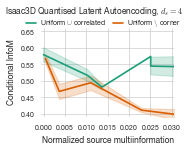

In [54]:
sns.set_theme(
    context='paper',
    style='whitegrid',
    font='Helvetica Neue',
    rc={
        'figure.constrained_layout.use':   True,
        # 'text.usetex':                      True,
        # 'font.family':                      'Helvetica',
        # 'text.latex.preamble':              r'\usepackage{bm}',
        'legend.framealpha':               1.0,
        'savefig.dpi':                     600,
        'savefig.pad_inches':              0.05,
        'savefig.transparent':             True,
        'mathtext.fontset':                'cm',
        'axes.formatter.use_mathtext':     True,
        'axes.labelsize':                  6,
        'axes.titlesize':                  6,
        'figure.titlesize':                6,
        'axes.labelpad':                   3,
        'xtick.labelsize':                 5,
        'xtick.major.pad':                 -0.5,
        'ytick.labelsize':                 5,
        'ytick.major.pad':                 -0.5,
        'grid.linewidth':                  0.5,
        'legend.fontsize':                 5,
        'hatch.linewidth':                 0.3,
        'lines.linewidth':                 1.2,
        'lines.markersize':                10,
        'figure.constrained_layout.w_pad': 0.03,
        'figure.constrained_layout.h_pad': 0.05
    }
)
sns.set_palette('Dark2')
fig, ax = plt.subplots(figsize=(1.8, 1.5))
sns.lineplot(
    data=df_im,
    x='source_normalized_multiinformation',
    y='cinfom',
    hue='group',
    hue_order=['image_correlated', 'image_slice'],
    markers=True,
    errorbar=('se', 0.5),
    ax=ax,
)

# ax.set_ylim(-0.02, 1.02)
ax.set_ylim(0.39, 0.66)
# ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticks(np.linspace(0.4, 0.65, 6))
ax.set_xlim(-0.0005, 0.0305)
ax.set_xticks([0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03])
handles, _ = ax.get_legend_handles_labels()
labels = [r'Uniform $\cup$ correlated', r'Uniform $\backslash$ corner']
ax.legend().set_visible(False)
fig.legend(
    handles, labels, loc='upper center', bbox_to_anchor=(0.55, 0.9),
    title=None, ncol=2, frameon=False, columnspacing=1, handletextpad=0.5,
    borderpad=0.05, borderaxespad=0.4, handlelength=1.5
)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_xlabel('Normalized source multiinformation')
ax.set_ylabel('Conditional InfoM')
fig.suptitle(r'Isaac3D Quantised Latent Autoencoding, $d_s=4$')
plt.savefig('qlae_isaac3d.pdf')


In [14]:
from metrics import compute_linear_metrics, multiinformation

data_path = 'FigureData/'

dropouts = [0, 1, 3, 6, 10, 15, 21, 28, 36]
data_distributions_3 = [
    np.load(data_path + f'panel_3/data_distribution_dropout_{dropout}.npy') for
    dropout in dropouts]
activity_data_3 = [np.load(
    data_path + f'panel_3/responses_dropout_{dropout}.npy', allow_pickle=True
) for dropout in dropouts]

correlations = [1, 2, 3, 4, 5]
data_distributions_4 = [
    np.load(data_path + f'panel_4/data_distribution_corr_{corr}.npy') for corr
    in correlations]
activity_data_4 = [
    np.load(data_path + f'panel_4/responses_corr_{corr}.npy', allow_pickle=True)
    for corr in correlations]

high_correlations = [10]
data_distributions_41 = [
    np.load(data_path + f'panel_4/data_distribution_corr_{corr}.npy') for corr
    in high_correlations]
activity_data_41 = [
    np.load(data_path + f'panel_4/responses_corr_{corr}.npy', allow_pickle=True)
    for corr in high_correlations]

diag_dropouts = [0, 1, 3, 5, 7, 9, 11, 13, 15, 17]
data_distributions_31 = [
    np.load(data_path + f'panel_3/data_distribution_diag_{dropout}.npy') for
    dropout in diag_dropouts]
activity_data_31 = [np.load(
    data_path + f'panel_3/responses_diag_{dropout}.npy', allow_pickle=True
) for dropout in diag_dropouts]

corner_lins = []
for i, dropout in enumerate(dropouts):
    dropout_corner_lins = []
    for j, response in enumerate(activity_data_3[i]):
        activations = np.array(response['activations']).reshape(-1, 25)
        inputs_info = response['input']

        sources = np.zeros((81, 2))
        latents = np.zeros((81, 25))

        for idx, info in enumerate(inputs_info):
            sources[idx, 0] = info['what_index']
            sources[idx, 1] = info['where_index']
            if data_distributions_3[i].flatten()[idx] == 1:
                latents[idx] = activations[idx]
            else:
                latents[idx] = np.nan
        sources = sources[~np.isnan(latents).any(axis=1)]
        latents = latents[~np.isnan(latents).any(axis=1)]
        lins = compute_linear_metrics(
            sources, latents, 'continuous', 'continuous'
        )
        # pprint(lins)
        dropout_corner_lins.append(lins)
    corner_lins.append(dropout_corner_lins)

diag_lins = []
for i, dropout in enumerate(diag_dropouts):
    dropout_diag_lins = []
    for j, response in enumerate(activity_data_31[i]):
        activations = np.array(response['activations']).reshape(-1, 25)
        inputs_info = response['input']

        sources = np.zeros((81, 2))
        latents = np.zeros((81, 25))

        for idx, info in enumerate(inputs_info):
            sources[idx, 0] = info['what_index']
            sources[idx, 1] = info['where_index']
            if data_distributions_31[i].flatten()[idx] == 1:
                latents[idx] = activations[idx]
            else:
                latents[idx] = np.nan
        sources = sources[~np.isnan(latents).any(axis=1)]
        latents = latents[~np.isnan(latents).any(axis=1)]
        lins = compute_linear_metrics(
            sources, latents, 'continuous', 'continuous'
        )
        # pprint(lins)
        dropout_diag_lins.append(lins)
    diag_lins.append(dropout_diag_lins)

all_corr_lins = []
for i, corr in enumerate(correlations):
    corr_lins = []
    for j, response in enumerate(activity_data_4[i]):
        activations = np.array(response['activations']).reshape(-1, 25)
        inputs_info = response['input']

        sources = np.zeros((81, 2))
        latents = np.zeros((81, 25))

        for idx, info in enumerate(inputs_info):
            sources[idx, 0] = info['what_index']
            sources[idx, 1] = info['where_index']
            if data_distributions_4[i].flatten()[idx] == 1:
                latents[idx] = activations[idx]
            else:
                latents[idx] = np.nan
        sources = sources[~np.isnan(latents).any(axis=1)]
        latents = latents[~np.isnan(latents).any(axis=1)]
        lins = compute_linear_metrics(
            sources, latents, 'continuous', 'continuous'
        )
        # pprint(lins)
        corr_lins.append(lins)
    all_corr_lins.append(corr_lins)

corner_nmis = []
for i, dropout in enumerate(dropouts):
    dropout_nmis = []
    for j, response in enumerate(activity_data_3[i]):
        activations = np.array(response['activations']).reshape(-1, 25)
        inputs_info = response['input']

        source1 = np.zeros((81, 1))
        source2 = np.zeros((81, 1))

        for idx, info in enumerate(inputs_info):
            if np.array(data_distributions_3[i]).flatten()[idx] == 1:
                source1[idx] = info['what_index']
                source2[idx] = info['where_index']
            else:
                source1[idx] = np.nan
                source2[idx] = np.nan
        source1 = source1[~np.isnan(source1).any(axis=1)]
        source2 = source2[~np.isnan(source2).any(axis=1)]
        # nmi = utils.mutual_information(source1, source2)
        sources = np.hstack((source1, source2))
        nmi = multiinformation(sources)['normalized_mi']
        dropout_nmis.append(nmi)
    corner_nmis.append(dropout_nmis)
corner_nmis = np.array([corner_nmi[0] for corner_nmi in corner_nmis])

diag_nmis = [] = []
for i, dropout in enumerate(diag_dropouts):
    dropout_nmis = []
    for j, response in enumerate(activity_data_31[i]):
        activations = np.array(response['activations']).reshape(-1, 25)
        inputs_info = response['input']

        source1 = np.zeros((81, 1))
        source2 = np.zeros((81, 1))

        for idx, info in enumerate(inputs_info):
            if np.array(data_distributions_31[i]).flatten()[idx] == 1:
                source1[idx] = info['what_index']
                source2[idx] = info['where_index']
            else:
                source1[idx] = np.nan
                source2[idx] = np.nan
        source1 = source1[~np.isnan(source1).any(axis=1)]
        source2 = source2[~np.isnan(source2).any(axis=1)]
        # nmi = utils.mutual_information(source1, source2)
        sources = np.hstack((source1, source2))
        nmi = multiinformation(sources)['normalized_mi']
        dropout_nmis.append(nmi)
    diag_nmis.append(dropout_nmis)
diag_nmis = np.array([diag_nmi[0] for diag_nmi in diag_nmis])

source1 = []
source2 = []
for d, dist in enumerate(data_distributions_4):
    model_source1 = []
    model_source2 = []
    for i, row in enumerate(dist):
        for j, el in enumerate(row):
            for k in range(int(el)):
                model_source1.append(i)
                model_source2.append(j)
    source1.append(model_source1)
    source2.append(model_source2)

corr_nmis = []
for i, corr in enumerate(correlations):
    s1 = np.array(source1[i]).reshape(-1, 1)
    s2 = np.array(source2[i]).reshape(-1, 1)
    sources = np.hstack((s1, s2))
    nmi = multiinformation(sources)['normalized_mi']
    corr_nmis.append(nmi)

all_lins = [corner_lins, diag_lins, all_corr_lins]
all_nmis = [corner_nmis, diag_nmis, corr_nmis]

In [15]:
groups = ['corner', 'diag', 'corr']
rows = []
for nmis, lins, group in zip(all_nmis, all_lins, groups):
    for nmi, lin in zip(nmis, lins):
        for run in lin:
            row = {
                'linear_cinfom': run['linear_cinfom'],
                'source_nmi':    nmi,
                'group':         group
            }
            rows.append(row)

df_ww = pd.DataFrame(rows)


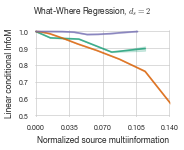

In [33]:
sns.set_theme(
    context='paper',
    style='whitegrid',
    font='Helvetica Neue',
    rc={
        'figure.constrained_layout.use':   True,
        # 'text.usetex':                      True,
        # 'font.family':                      'Helvetica',
        # 'text.latex.preamble':              r'\usepackage{bm}',
        'legend.framealpha':               1.0,
        'savefig.dpi':                     600,
        'savefig.pad_inches':              0.05,
        'savefig.transparent':             True,
        'mathtext.fontset':                'cm',
        'axes.formatter.use_mathtext':     True,
        'axes.labelsize':                  6,
        'axes.titlesize':                  6,
        'figure.titlesize':                6,
        'axes.labelpad':                   3,
        'xtick.labelsize':                 5,
        'xtick.major.pad':                 -0.5,
        'ytick.labelsize':                 5,
        'ytick.major.pad':                 -0.5,
        'grid.linewidth':                  0.5,
        'legend.fontsize':                 5,
        'hatch.linewidth':                 0.3,
        'lines.linewidth':                 1.2,
        'lines.markersize':                10,
        'figure.constrained_layout.w_pad': 0.03,
        'figure.constrained_layout.h_pad': 0.05
    }
)
fig, ax = plt.subplots(figsize=(1.8, 1.5))
sns.set_palette('Dark2')
sns.lineplot(
    data=df_ww,
    x='source_nmi',
    y='linear_cinfom',
    hue='group',
    hue_order=['corr', 'corner', 'diag'],
    markers=True,
    errorbar=('se', 1),
    ax=ax,
    alpha=0.8
)

ax.set_ylim(0.49, 1.01)
ax.set_yticks(np.linspace(0.5, 1.0, 6))
ax.set_xlim(-0.0005, 0.1405)
ax.set_xticks(np.linspace(0, 0.14, 5))
handles, labels = ax.get_legend_handles_labels()
# labels = [r'Uniform $\cup$ correlated', r'Uniform $\backslash$ slice']
labels = [r'Uniform $\cup$ correlated', r'Uniform $\backslash$ corner',
          r'Uniform $\backslash$ diagonal']
ax.legend().set_visible(False)
# fig.legend(
#     handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.91),
#     title=None, ncol=3, frameon=False, columnspacing=0.5, handletextpad=0.4,
#     borderpad=0.05, borderaxespad=0.4, handlelength=1.5
# )
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_xlabel('Normalized source multiinformation')
ax.set_ylabel('Linear conditional InfoM')
fig.suptitle(r'What-Where Regression, $d_s = 2$')
plt.savefig('what_where.pdf')


In [36]:
all_nmis[0]

array([2.02113709e-16, 2.53441379e-03, 7.18466522e-03, 1.36957771e-02,
       2.19452468e-02, 3.19197637e-02, 4.36749577e-02, 5.71783892e-02,
       7.14735901e-02])